# HW5. De Bruijn graph

TODOS:
1. Choose length of enpoints to drop
2. Choose kmer coverage theshold
3. How to treat complementarity?

In [285]:
import time

from Bio import SeqIO
from graphviz import Source

In [264]:
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 


def rc(seq):
    """Reverse-complement sequence"""
    return ''.join(reversed([complement.get(base,base) for base in seq]))

In [281]:
CUTOFF_K = 2
CUTOFF_COV = 0.4


class Vertex:
    
    def __init__(self, seq, forward=True):
        self.seq = seq
        self.incoming = {}
        self.outcoming = {}
        self.complement = rc(seq)
        self.forward = forward
        
    def add_outcoming(self, edge):
        self.outcoming[edge.seq] = edge
    
    def add_incoming(self, edge):
        self.incoming[edge.seq] = edge
        
    @property
    def is_linear(self):
        return (len(self.incoming) == 1) and (len(self.outcoming) == 1)
    
    @property
    def is_endpoint(self):
        return (len(self.incoming) == 1) and (len(self.outcoming) == 0)
    
    @property
    def is_startpoint(self):
        return (len(self.incoming) == 0) and (len(self.outcoming) == 1)
    
    @property
    def chain(self):
        if self.is_linear:
            return list(self.incoming.values())[0], list(self.outcoming.values())[0]
        
        if self.is_startpoint:
            return None, list(self.outcoming.values())[0]
        
        if self.is_endpoint:
            return list(self.incoming.values())[0], None
        
        return None, None
            

class Edge:
    
    def __init__(self, v_from, v_to, seq, cov=None, forward=True):
        self.v_from = v_from
        self.v_to = v_to
        self.seq = seq
        self.complement = rc(seq)
        self.cov = cov or [1]
        self.forward = forward
        
    @classmethod
    def merge_edges(cls, edge_in, edge_out, k):
        seq = edge_in.seq[:-k+1] + edge_out.seq
        cov = edge_in.cov + edge_out.cov
        
        return cls(edge_in.v_from, edge_out.v_to, seq, cov)
        
    @property
    def n_kmers(self):
        return len(self.cov)
    
    @property
    def size(self):
        return len(self.seq)
    
    @property
    def avg_cov(self):
        return sum(self.cov) / self.n_kmers


class DeBruijnGraph:
    
    def __init__(self, fasta_filepath, k=None):
        self.fasta_filepath = fasta_filepath
        self.edges = {}
        self.vertexes = {}
        self._build(k)
    
    def _build(self, k):
        self.k = k or self._find_k()
        self._build_vetrexes()
        self._build_edges()
    
    @property
    def _reads(self):
        ext = self.fasta_filepath[-5:]
        return SeqIO.parse(open(self.fasta_filepath), ext)
    
    def _find_k(self):
        max_read_len = 0
        for read in self._reads:
            seq_len = len(read.seq)
            if seq_len > max_read_len:
                max_read_len = seq_len
        
        best_k = (max_read_len + 1) // 2
        best_k = best_k if best_k % 2 == 1 else best_k + 1
        print(f"--- K infered from reads: {best_k}.")
        return best_k
    
    def _add_vertex(self, sequence):
        for seq, fwd in ((sequence, True), (rc(sequence), False)):
            if seq not in self.vertexes:
                self.vertexes[seq] = Vertex(seq, forward=fwd)
            
    def _build_vetrexes(self):
        for read in self._reads:
            sequence = str(read.seq)
            for i in range(0, len(sequence) - self.k + 1):
                self._add_vertex(sequence[i:i + self.k])
                
    def _add_edge(self, sequence):
        for seq, fwd in ((sequence, True), (rc(sequence), False)):
            if seq not in self.edges:
                seq_from, seq_to = seq[:-1], seq[1:]
                v_from, v_to = self.vertexes[seq_from], self.vertexes[seq_to]

                edge = Edge(v_from, v_to, seq, forward=fwd)
                self.edges[seq] = edge
                v_from.add_outcoming(edge)
                v_to.add_incoming(edge)
            else:
                self.edges[seq].cov[0] += 1
            
    def _build_edges(self):
        for read in self._reads:
            sequence = str(read.seq)
            for i in range(0, len(sequence) - self.k):
                self._add_edge(sequence[i:i + self.k + 1])
                
    def avg_cov(self):
        n_kmers = 0
        total_cov = 0
        for seq, edge in self.edges.items():
            n_kmers += edge.n_kmers
            total_cov += sum(edge.cov)
        return total_cov / n_kmers
    
    def _cutoff_cov(self):
        return self.avg_cov() * CUTOFF_COV
    
    def remove_tails(self):
        remove_verts = []
        cov_limit = self._cutoff_cov()
        
        for seq, vertex in self.vertexes.items():
            if vertex.is_endpoint:
                edge_in, _ = vertex.chain
                if (len(edge_in.seq) < CUTOFF_K * self.k) or (edge_in.avg_cov < cov_limit):
                    edge_in.v_from.outcoming.pop(edge_in.seq)
                    remove_verts.append(seq)
                    self.edges.pop(edge_in.seq)
                
            if vertex.is_startpoint:
                _, edge_out = vertex.chain
                if (len(edge_out.seq) < CUTOFF_K * self.k) and (edge_out.avg_cov < cov_limit):
                    edge_out.v_to.incoming.pop(edge_out.seq)
                    remove_verts.append(seq)
                    self.edges.pop(edge_out.seq)
                    
        for seq in remove_verts:
            self.vertexes.pop(seq)
    
    def remove_bad_edges(self):
        remove_edges = []
        cov_limit = self._cutoff_cov()
        for seq, edge in self.edges.items():
            if edge.avg_cov < cov_limit:
                edge.v_to.incoming.pop(seq)
                edge.v_from.outcoming.pop(seq)
                remove_edges.append(seq)
                
        for seq in remove_edges:
            self.edges.pop(seq)
    
    def simplify(self):
        remove_verts = []
        for seq, vertex in self.vertexes.items():
            if vertex.is_linear:
                edge_in, edge_out = vertex.chain
                new_edge = Edge.merge_edges(edge_in, edge_out, self.k + 1)
                
                edge_in.v_from.outcoming.pop(edge_in.seq)
                edge_in.v_from.outcoming[new_edge.seq] = new_edge
                edge_out.v_to.incoming.pop(edge_out.seq)
                edge_out.v_to.incoming[new_edge.seq] = new_edge
                
                self.edges.pop(edge_in.seq)
                self.edges.pop(edge_out.seq)
                self.edges[new_edge.seq] = new_edge
                
                remove_verts.append(seq)
                
        for seq in remove_verts:
            self.vertexes.pop(seq)
            
    def process(self):
        print('Starting condencation.')
        self.simplify()
        self.remove_bad_edges()
        self.remove_tails()
        self.simplify()
        self.remove_bad_edges()
        self.remove_tails()
        self.simplify()
        self.remove_bad_edges()
        self.remove_tails()
        self.simplify()
            
    def dot_graph(self):
        graph_verts = {}
        i = 0
        s = 'digraph new_graph {\n'
        for seq, edge in self.edges.items():
            label_from = graph_verts.get(edge.v_from.seq, None)
            if label_from is None:
                label_from = f'V{i}'
                graph_verts[edge.v_from.seq] = label_from
                i += 1
            label_to = graph_verts.get(edge.v_to.seq, None)
            if label_to is None:
                label_to = f'V{i}'
                graph_verts[edge.v_to.seq] = label_to
                i += 1
            
            s += f'    {label_from} -> {label_to} [label="len: {edge.size}, cov: {edge.avg_cov:.0f}"];\n'
        s += '}\n'
        return s
    
    def plot(self):
        return Source(self.dot_graph())
    
    def to_png(self, filename=None):
        self.plot().render(filename, format='png')
    
    def to_dot(self, filename):
        with open(filename, 'w') as f:
            f.write(self.dot_graph())
    
    def to_fasta(self, filename):
        with open(filename, 'w') as f:
            for i, edge in enumerate(self.edges):
                f.write(f'>contig_{i}\n')
                f.write(edge + '\n')


## Try on real data
### s_6.first1000.fastq

In [286]:
def run_on_first(l):
    start_time = time.monotinic()
    g = DeBruijnGraph(f'data/graph/s_6.first{l}.fastq', 55)
    g.process()
    print(f'Assembly finished in {time.monotinic() - start_time:.2f} sec with coverage: {g.avg_cov()}.')
    g.to_fasta(f'output/db_graph_{l}.fasta')
    g.to_png(f'images/db_graph_{l}')
    g.plot()

155.6778042959427


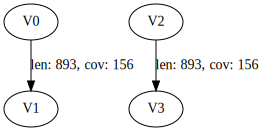

In [282]:
l = 1000
run_on_first(l)

### s_6.first10000.fastq

204.01809954751133


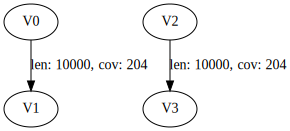

In [283]:
l = 10000
run_on_first(l)

### s_6.first100000.fastq

224.79804866815846


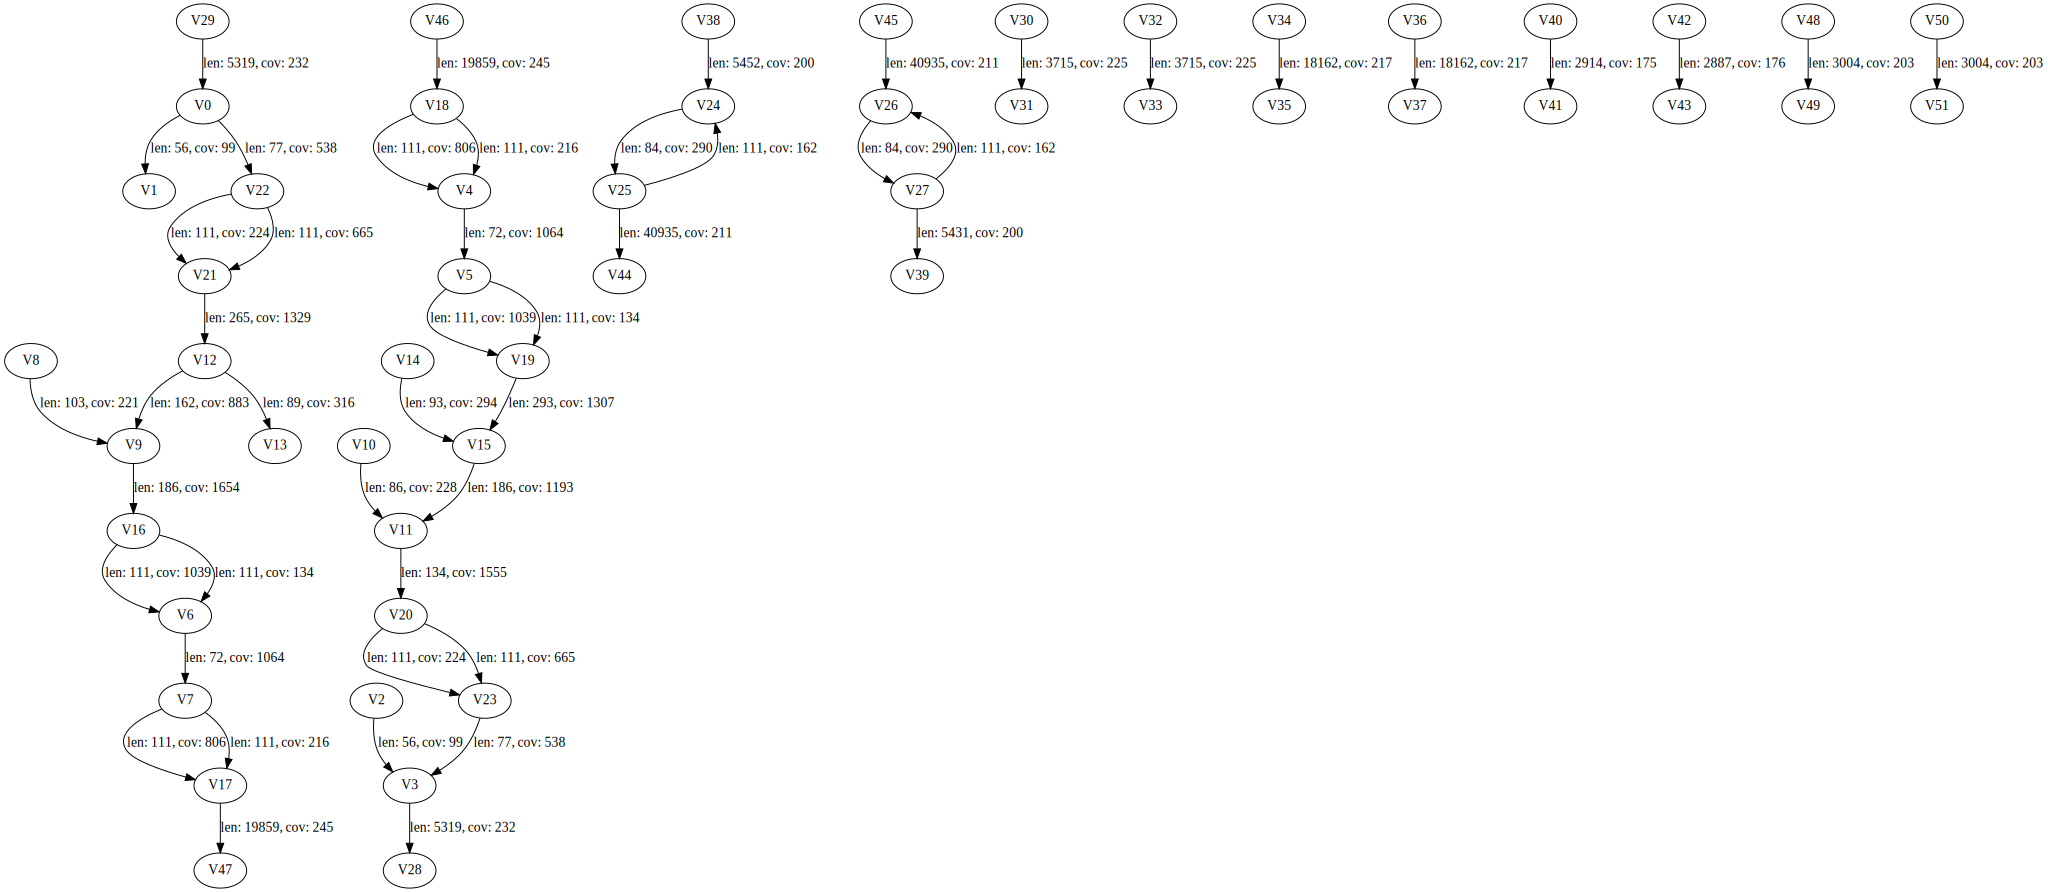

In [284]:
l = 100000
run_on_first(l)